In [16]:
# upgrade libraries
# !pip install --user --upgrade scikit-learn tensorflow keras keras-tuner tensorboard numpy pandas matplotlib
# pip freeze > requirements.txt
# !pip install --user --upgrade -r requirements.txt

In [17]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib_inline.backend_inline
import plotly.express as px
from ydata_profiling import ProfileReport

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, MaxPooling1D, TimeDistributed, Reshape, Flatten, Dense, Dropout, LSTM, Conv1D
from tensorflow.keras.callbacks import TensorBoard
import tensorboard as tb
from keras_tuner.tuners import BayesianOptimization
from keras_tuner.engine.hyperparameters import HyperParameters

from RectEIT import RectEIT
from utils import *

import os
import warnings
import pickle

pd.set_option('display.max_rows', 50)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib notebook
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

TB_LOG_DIR = "model_logs/fit"  # Specify the directory for storing TensorBoard logs

tensorboard_callback = TensorBoard(
    log_dir=TB_LOG_DIR,
    histogram_freq=1,  # Frequency (in epochs) for computing histograms
    write_graph=True,  # Whether to write the model graph visualization
    update_freq='epoch'  # Frequency (in 'batch' or 'epoch') for writing TensorBoard summaries
)

BASE_PATH = r'C:\Users\lnick\Documents\UROP\EIT_Touch_Sensor'
DATA_SOURCE_1 = 'output/EIT_Data_Gelatin_1_finger_2_dof.xlsx'
DATA_SOURCE_2 = 'output/EIT_Data_Gelatin_2_fingers_4_dof.xlsx'

setup = RectEIT()

In [18]:
X = pd.read_excel(os.path.join(BASE_PATH, DATA_SOURCE_1), sheet_name='Voltages')
y_orig = pd.read_excel(os.path.join(BASE_PATH, DATA_SOURCE_1), sheet_name='Positions')
y_orig.dropna(axis=1, how='all', inplace=True)
print(X.shape, y_orig.shape)  # expect: x: (3200, 1024), y_orig: (3200, 2)

(3200, 1024) (3200, 2)


In [19]:
y = convert_xy_to_disp_map(y_orig.values)
print(y.shape)  # expect: (3200, 6, 8)
print(y[0, ...])

(3200, 6, 8)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


In [20]:
# check spread of (x, y) coordinates
fig_pos = px.density_heatmap(y_orig, x='x1', y='y1', marginal_x='histogram', marginal_y='histogram', nbinsx=10, nbinsy=10)
fig_pos.show()

# analyse positions
ProfileReport(y_orig)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

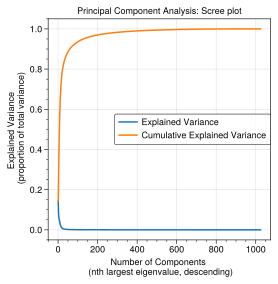

In [21]:
# exploratory PCA
X_std_df = StandardScaler().fit_transform(X)
pca = PCA(n_components=None)
df_pca = pd.DataFrame(pca.fit_transform(X_std_df))
explained_variance = pca.explained_variance_ratio_
plt.plot(range(1, len(explained_variance) + 1), explained_variance, label='Explained Variance')
plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), label='Cumulative Explained Variance')
plt.xlabel('Number of Components \n ($n$th largest eigenvalue, descending)')
plt.ylabel('Explained Variance \n (proportion of total variance)')
plt.legend()
plt.title('Principal Component Analysis: Scree plot')
plt.show()

# 128 components is a good cutoff - about 95% of variance explained

## Classical Regression Algorithms

Models tested:

- Linear regression with PCA
- Polynomial regression with PCA
- Polynomial regression with PCA and regularisation (Lasso and Ridge)
- Random forest
- Support vector machine
- K-nearest neighbours regression
- Multilayer perceptron (simple fully connected neural network)

All models use K-fold cross-validation and optimise hyperparameters to find the best MSE.

In [22]:
# train a series of regression models:
# simple linear, polynomial, lasso, ridge, random forest, svr, knn, mlp
# PCA is used for poly/ridge/lasso

pipeline_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=25)),
    ('regression', LinearRegression())
])

pipeline_poly = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('poly', PolynomialFeatures()),
    ('regression', LinearRegression())
])

pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('poly', PolynomialFeatures(degree=2)),
    ('ridge', Ridge())
])

pipeline_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('poly', PolynomialFeatures(degree=2)),
    ('lasso', Lasso())
])

pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor())
])

pipeline_svr = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', MultiOutputRegressor(SVR()))
])

pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

pipeline_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor())
])

# hyperparameter key syntax: 'name in pipeline__attribute'
param_grid_linear = {'pca__n_components': [2, 10, 128, 1024]}
param_grid_poly = {'poly__degree': [2, 3]}
param_grid_ridge = {'ridge__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 1e10]}
param_grid_lasso = {'lasso__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 1e10]}
param_grid_rf = {'rf__n_estimators': [10, 100, 1000]}
param_grid_svr = {'svr__estimator__C': [0.001, 0.01, 0.1], 'svr__estimator__epsilon': [0.001, 0.01, 0.1]}
param_grid_knn = {'knn__n_neighbors': [2, 4, 6, 8, 10]}
param_grid_mlp = {'mlp__hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100)],
    'mlp__activation': ['relu', 'tanh', 'logistic'],
    'mlp__alpha': [0.01, 0.1, 1.0]}

def train_model(X: np.ndarray, y: np.ndarray, pipeline: Pipeline, param_grid: dict[str: list],
        model_name: str = '', test_size: float = 0.2, cv: int = 10,
        scoring: str = 'neg_mean_squared_error') -> Pipeline:
    '''
    Train and evaluate a model using grid search cross validation.
    
    #### Arguments
    
    `X` (np.ndarray): full input dataset (features)
    `y` (np.ndarray): full output dataset (target variable)
    `pipeline` (Pipeline): sequence of processing steps and a final estimator.
    `param_grid` (dict[str: list]): set of hyperparameters to search over.
    Key syntax: 'name in pipeline__attribute'
    `test_size` (float, default = 0.2): proportion of dataset to use for testing.
    `cv` (int, default = 10): number of folds in cross validation.
    `scoring` (str, default = 'neg_mean_squared_error'): scoring metric for cross validation.
    
    #### Returns
    
    `Pipeline`: the best model found by grid search cross validation.
    '''

    mape = lambda y_test, y_pred: round(mean_absolute_percentage_error(y_test, y_pred), 5)
    mae = lambda y_test, y_pred: round(mean_absolute_error(y_test, y_pred), 5)
    rmse = lambda y_test, y_pred: round(mean_squared_error(y_test, y_pred, squared=False), 5)

    X_train, X_test, y_train, y_test = train_test_split(X, y_orig, test_size=test_size)
    search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring=scoring)
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    print(f'{model_name} - Best hyperparameters: {search.best_params_}')
    print(f'MAPE: {mape(y_test, y_pred)}, '
          f'MAE: {mae(y_test, y_pred)}, '
          f'RMSE: {rmse(y_test, y_pred)}')
    return best_model


linear_model = train_model(X, y_orig, pipeline_linear, param_grid_linear, model_name='Linear')
poly_model = train_model(X, y_orig, pipeline_poly, param_grid_poly, model_name='Poly')
ridge_model = train_model(X, y_orig, pipeline_ridge, param_grid_ridge, model_name='Ridge')
lasso_model = train_model(X, y_orig, pipeline_lasso, param_grid_lasso, model_name='Lasso')
rf_model = train_model(X, y_orig, pipeline_rf, param_grid_rf, cv=3, model_name='Random Forest')
svr_model = train_model(X, y_orig, pipeline_svr, param_grid_svr, cv=3, model_name='SVR')
knn_model = train_model(X, y_orig, pipeline_knn, param_grid_knn, cv=3, model_name='KNN')
mlp_model = train_model(X, y_orig, pipeline_mlp, param_grid_mlp, cv=3, model_name='MLP')

KeyboardInterrupt: 

# Neural Net for Predicting Position

Simple Neural Net:

In [23]:
# get test/train sets
X_train, X_test, y_train, y_test = train_test_split(X, y_orig, test_size=0.2)

In [ ]:
# build model
model_fcnn = Sequential()
model_fcnn.add(Input(shape=(1024,)))
model_fcnn.add(Dense(units=512, activation='relu'))
model_fcnn.add(Dense(units=256, activation='relu'))
model_fcnn.add(Dense(units=2, activation='linear'))
model_fcnn.compile(optimizer='adam', loss='mse')
model_fcnn.summary()

# train model
history = model_fcnn.fit(X_train, y_train, epochs=200, batch_size=128, callbacks=[tensorboard_callback])
plt.plot(history.history['loss'], label='First FC NN')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

# test model
results = model_fcnn.evaluate(X_test, y_test, batch_size=128)
print(results)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
Total params: 656642 (2.50 MB)
Trainable params: 656642 (2.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200


ValueError: in user code:

    File "c:\Users\lnick\anaconda3\envs\AllLibs310\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\lnick\anaconda3\envs\AllLibs310\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\lnick\anaconda3\envs\AllLibs310\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\lnick\anaconda3\envs\AllLibs310\lib\site-packages\keras\src\engine\training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\lnick\anaconda3\envs\AllLibs310\lib\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "c:\Users\lnick\anaconda3\envs\AllLibs310\lib\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\lnick\anaconda3\envs\AllLibs310\lib\site-packages\keras\src\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\lnick\anaconda3\envs\AllLibs310\lib\site-packages\keras\src\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\lnick\anaconda3\envs\AllLibs310\lib\site-packages\keras\src\losses.py", line 1608, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 2 and 4 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential/dense_2/BiasAdd, Cast)' with input shapes: [128,2], [128,4].


Hyperparameter optimisation:

In [ ]:
def build_model(hp: HyperParameters) -> Sequential:
    model_fcnn = Sequential()
    model_fcnn.add(Input(shape=(1024,)))
    model_fcnn.add(Dense(units=hp.Int('units_1', min_value=128, max_value=1024, step=128), activation='relu'))
    model_fcnn.add(Dense(units=hp.Int('units_2', min_value=64, max_value=512, step=128), activation='relu'))
    model_fcnn.add(Dense(units=2, activation='linear'))
    model_fcnn.compile(optimizer='adam', loss='mse')
    model_fcnn.summary()
    return model_fcnn

tuner = BayesianOptimization(build_model, objective='val_loss', max_trials=10,
    directory='src/tuner_dir', project_name='my_tuner')

# find best hyperparameters - use 100 epochs instead of 200 to save time
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test))
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# train best model
best_history = best_model.fit(X_train, y_train, epochs=200, batch_size=128, callbacks=[tensorboard_callback])
plt.plot(history.history['loss'], label='First FC network')
plt.plot(best_history.history['loss'], label='Best FC network')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# test best model
best_loss = best_model.evaluate(X_test, y_test)
print(best_hyperparameters.values)
print(best_loss)

# save best model
best_model.save('models-4-dof/fcnn_1_finger.keras')

Trial 10 Complete [00h 18m 51s]
val_loss: 0.0005899999523535371

Best val_loss So Far: 0.0005510456394404173
Total elapsed time: 02h 33m 14s
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 640)               656000    
                                                                 
 dense_1 (Dense)             (None, 448)               287168    
                                                                 
 dense_2 (Dense)             (None, 2)                 898       
                                                                 
Total params: 944066 (3.60 MB)
Trainable params: 944066 (3.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Check random samples from train set and test set:

1/1 [==============================] - 0s 75ms/step


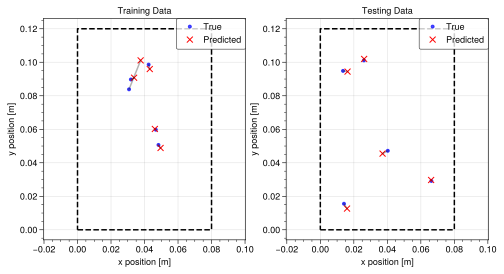

In [40]:
fig, (ax_train, ax_test) = plt.subplots(1, 2, figsize=(8, 4))
ax_train.set_title('Training Data')
ax_train.set_xlabel('x position [m]')
ax_train.set_ylabel('y position [m]')
ax_test.set_title('Testing Data')
ax_test.set_xlabel('x position [m]')
ax_test.set_ylabel('y position [m]')
ax_train.set_xlim([0, setup.FRAME_X])
ax_train.set_ylim([0, setup.FRAME_Y])
ax_test.set_xlim([0, setup.FRAME_X])
ax_test.set_ylim([0, setup.FRAME_Y])

# choose 5 random rows from the training and testing sets each
samples_i = np.random.choice(X_train.shape[0], 5, replace=False)
X_sample_train = X_train.iloc[samples_i].values
y_sample_train = y_train.iloc[samples_i].values
y_pred_train = best_model.predict(X_sample_train)

samples_i = np.random.choice(X_test.shape[0], 5, replace=False)
X_sample_test = X_test.iloc[samples_i].values
y_sample_test = y_test.iloc[samples_i].values
y_pred_test = best_model.predict(X_sample_test)

# plot training data
ax_train.plot(y_sample_train[:, 0], y_sample_train[:, 1], 'b.', label=f'True', alpha=0.7)
ax_train.plot(y_pred_train[:, 0], y_pred_train[:, 1], 'rx', label=f'Predicted')
for i in range(len(y_sample_train)):
    ax_train.plot([y_sample_train[i, 0], y_pred_train[i, 0]], [y_sample_train[i, 1], y_pred_train[i, 1]],
        'k-', alpha=0.3)
ax_train.plot([0, x_lim, x_lim, 0, 0], [0, 0, y_lim, y_lim, 0], 'k--')
ax_train.axis('equal')
ax_train.legend(loc='upper right')

# plot test data
ax_test.plot(y_sample_test[:, 0], y_sample_test[:, 1], 'b.', label=f'True', alpha=0.7)
ax_test.plot(y_pred_test[:, 0], y_pred_test[:, 1], 'rx', label=f'Predicted')
for i in range(len(y_sample_test)):
    ax_test.plot([y_sample_test[i, 0], y_pred_test[i, 0]], [y_sample_test[i, 1], y_pred_test[i, 1]],
        'k-', alpha=0.3)
ax_test.plot([0, x_lim, x_lim, 0, 0], [0, 0, y_lim, y_lim, 0], 'k--')
ax_test.axis('equal')
ax_test.legend(loc='upper right')

plt.show()

# ConvNet for predicting displacement